In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import shutil

In [4]:
source_directories = [
    'brain_tumor_dataset/no/',
    'brain_tumor_dataset/yes/'
]
destination_directory = '/kaggle/temp/'
os.makedirs(os.path.join(destination_directory, 'no'), exist_ok=True)
os.makedirs(os.path.join(destination_directory, 'yes'), exist_ok=True)
for source_dir in source_directories:
    category = 'no' if 'no' in source_dir else 'yes'
    files = os.listdir(source_dir)
    
    for file in files:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_directory, category, file)
        
        shutil.copy(source_path, destination_path)
        
print("File copying completed.")

File copying completed.


In [5]:
data_dir = "/kaggle/temp/"
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

253


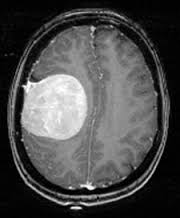

In [6]:
yes = list(data_dir.glob('yes/*'))
PIL.Image.open(str(yes[0]))

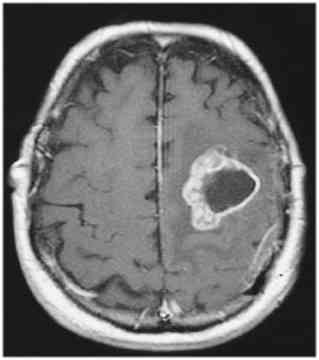

In [7]:
PIL.Image.open(str(yes[1]))

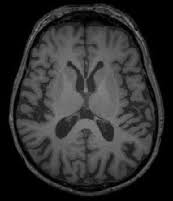

In [8]:
no = list(data_dir.glob('no/*'))
PIL.Image.open(str(no[1]))

In [9]:
batch_size = 32
img_height = 244
img_width = 244

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [12]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['no', 'yes']


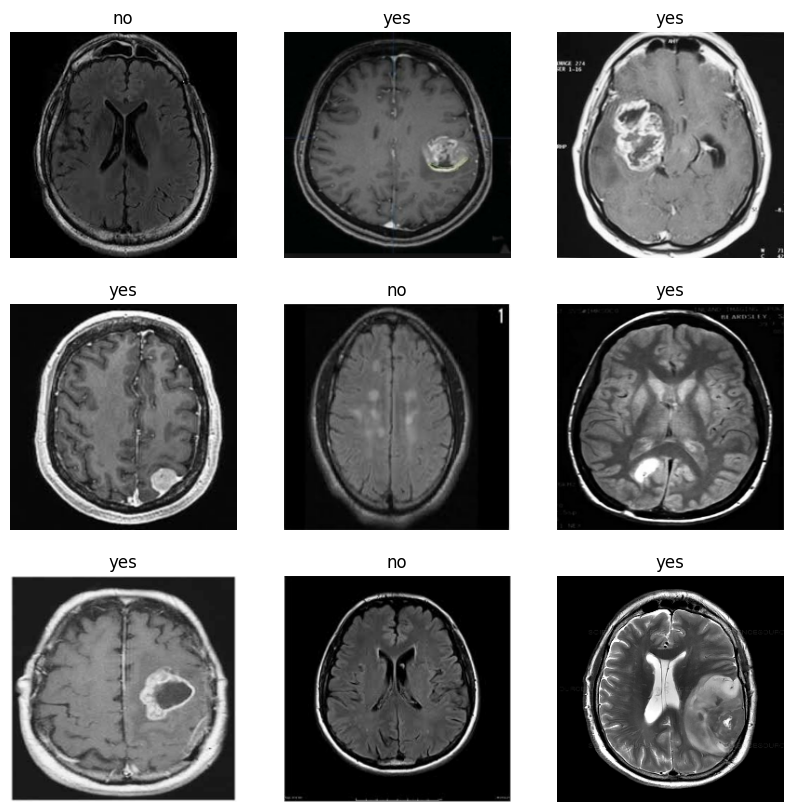

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 244, 244, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

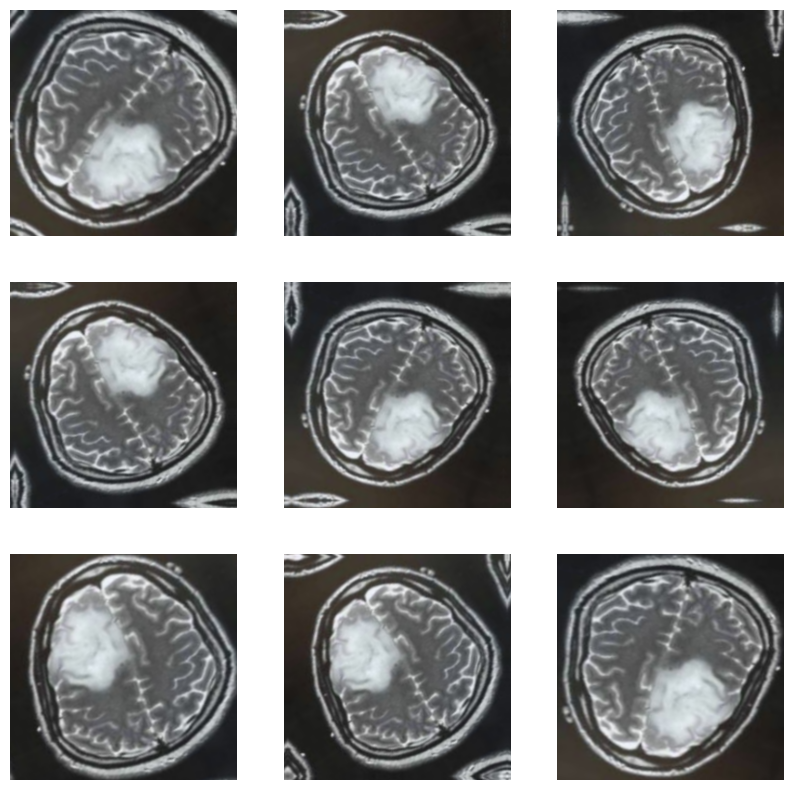

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, (4,4), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, (4,4), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(24, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
import time
from tensorflow.keras.callbacks import EarlyStopping

epochs = 300

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time = time.time()

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

end_time = time.time()

inference_time_per_epoch = (end_time - start_time) / epochs

best_epoch = early_stopping.stopped_epoch + 1 

best_train_accuracy = history1.history['accuracy'][best_epoch - 1]
best_val_accuracy = history1.history['val_accuracy'][best_epoch - 1]
best_train_loss = history1.history['loss'][best_epoch - 1]
best_val_loss = history1.history['val_loss'][best_epoch - 1]

print("Best Epoch:", best_epoch)
print("Best Training Accuracy:", best_train_accuracy)
print("Best Validation Accuracy:", best_val_accuracy)
print("Best Training Loss:", best_train_loss)
print("Best Validation Loss:", best_val_loss)
print("Inference Time per Epoch:", inference_time_per_epoch, "seconds")

Epoch 1/300
7/7 [==============================] - 12s 633ms/step - loss: 0.6994 - accuracy: 0.5714 - val_loss: 0.6520 - val_accuracy: 0.6400
Epoch 2/300
7/7 [==============================] - 3s 418ms/step - loss: 0.6149 - accuracy: 0.6158 - val_loss: 0.6558 - val_accuracy: 0.6400
Epoch 3/300
7/7 [==============================] - 3s 471ms/step - loss: 0.5682 - accuracy: 0.6995 - val_loss: 0.6730 - val_accuracy: 0.5800
Epoch 4/300
7/7 [==============================] - 3s 412ms/step - loss: 0.5763 - accuracy: 0.6995 - val_loss: 0.5840 - val_accuracy: 0.8000
Epoch 5/300
7/7 [==============================] - 3s 403ms/step - loss: 0.6053 - accuracy: 0.7143 - val_loss: 0.5918 - val_accuracy: 0.7400
Epoch 6/300
7/7 [==============================] - 3s 408ms/step - loss: 0.5807 - accuracy: 0.7241 - val_loss: 0.5657 - val_accuracy: 0.7800
Epoch 7/300
7/7 [==============================] - 3s 403ms/step - loss: 0.5425 - accuracy: 0.7685 - val_loss: 0.6251 - val_accuracy: 0.7800
Epoch 8/300


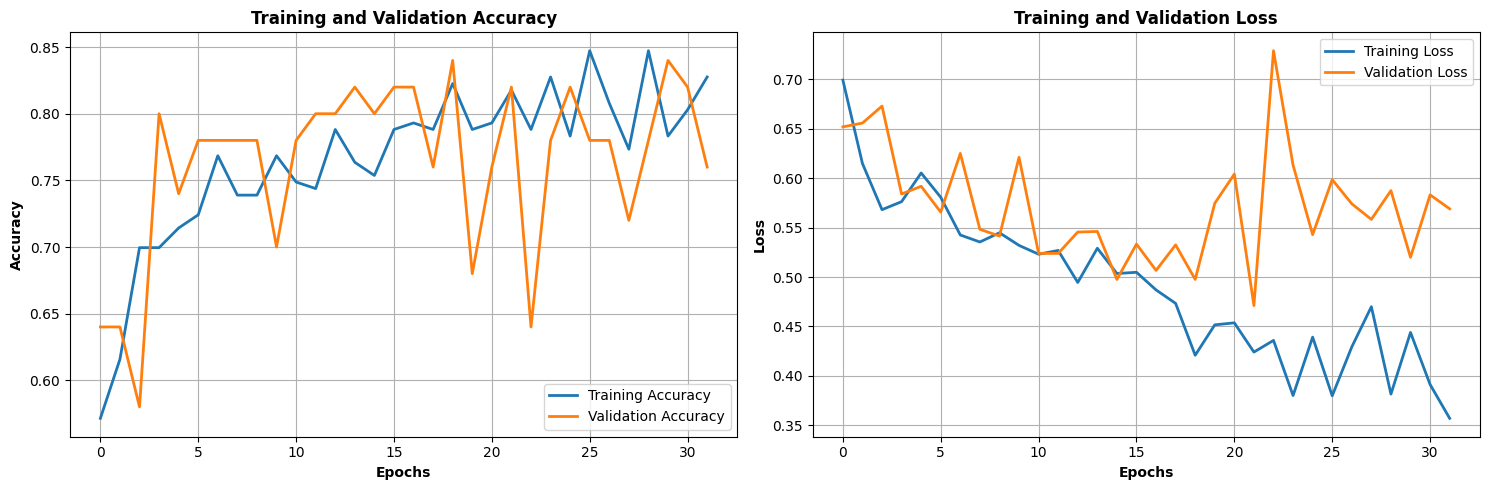

In [20]:
import matplotlib.pyplot as plt

color1 = '#1f77b4'  # Blue
color2 = '#ff7f0e'  # Orange

# Accuracy and loss data
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy', color=color1, linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', color=color2, linewidth=2)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.plot(loss, label='Training Loss', color=color1, linewidth=2)
plt.plot(val_loss, label='Validation Loss', color=color2, linewidth=2)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report

val_predictions = model.predict(val_ds)

val_true_labels = []
for images, labels in val_ds:
    val_true_labels.extend(labels.numpy())

val_true_labels = np.array(val_true_labels)

val_predicted_labels = np.argmax(val_predictions, axis=1)

print(classification_report(val_true_labels, val_predicted_labels, target_names=class_names))

2/2 [==============================] - 0s 38ms/step
              precision    recall  f1-score   support

          no       0.85      0.61      0.71        18
         yes       0.81      0.94      0.87        32

    accuracy                           0.82        50
   macro avg       0.83      0.77      0.79        50
weighted avg       0.82      0.82      0.81        50



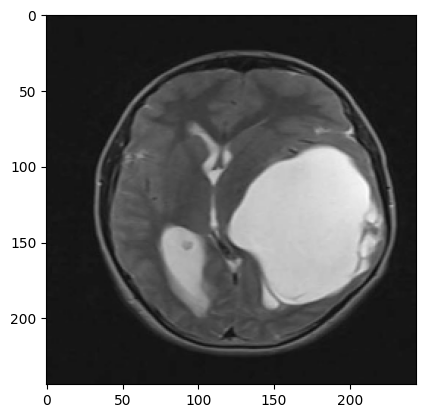

1/1 [==============================] - 0s 20ms/step
[1]


In [31]:
import cv2

img=cv2.imread('testing/brain-tumor-2.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

resize=tf.image.resize(img,(244,244))
plt.imshow(resize.numpy().astype(int))
plt.show()

#np.expand_dims(resize,0)
#yhat=model.predict(np.expand_dims(resize/255,0))
#class_labels = np.argmax(yhat,axis=-1)
#print(class_labels)
predicted=np.argmax(model.predict(np.expand_dims(resize,0)),axis=1)
print(predicted)